# 1.Import zbioru danych

In [45]:
#import bibliotek
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas as pd
import xgboost, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

import nltk

from textblob import TextBlob

import numpy as np

In [46]:
#pobierz słowa ze stoplisty
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=stopwords.words('english')

#pobierz Punkt Tokenizer Models
nltk.download('punkt')

#pobierz angielską bazę danych rzeczowników, czasowników, przymiotników, przysłówków i zaimków
from textblob import Word
nltk.download('wordnet')

#pobierz Greedy Averaged Perceptron tagger
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kacper\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kacper\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kacper\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kacper\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [114]:
#załaduj zbiór danych
train=pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("Corona_NLP_test.csv",encoding='latin1')
#połączenie zbiorów w jeden w celu późniejszego podziału według potrzeby programu
trainDF = pd.concat([train,test])
trainDF['Sentiment']=trainDF['Sentiment'].astype(str)
trainDF

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [115]:
#zredukuj opcje do 3 (pozytywna, negatywna i neutralna)

trainDF["Sentiment"] = trainDF["Sentiment"].astype(str)

def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
trainDF['Sentiment']=trainDF['Sentiment'].apply(lambda x:classes_def(x))
trainDF

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,negative


In [116]:
#stwórz kopię zbioru danych
train = trainDF.copy()
#wyświetl 100 rekordów
print(train.head(100))
#wyświetl informacje o zbiorze danych
print(trainDF.describe())

    UserName  ScreenName                    Location     TweetAt  \
0       3799       48751                      London  16-03-2020   
1       3800       48752                          UK  16-03-2020   
2       3801       48753                   Vagabonds  16-03-2020   
3       3802       48754                         NaN  16-03-2020   
4       3803       48755                         NaN  16-03-2020   
..       ...         ...                         ...         ...   
95      3894       48846  FREE goal setting guide ??  16-03-2020   
96      3895       48847              Washington, DC  16-03-2020   
97      3896       48848              Washington, DC  16-03-2020   
98      3897       48849       San Joaquin Valley CA  16-03-2020   
99      3898       48850                Planet Earth  16-03-2020   

                                        OriginalTweet Sentiment  
0   @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   neutral  
1   advice Talk to your neighbours family to excha.

## 1.2 Analiza zbioru danych

In [117]:
#sprawdź liczbę słów w tweecie
train['word_count']=train['OriginalTweet'].apply(lambda x: len(str(x).split(" ")))
train[['OriginalTweet', 'word_count']].head(10)

,OriginalTweet,word_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,8
1,advice Talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,14
3,My food stock is not the only one which is emp...,40
4,"Me, ready to go at supermarket during the #COV...",38
5,As news of the regionÂs first confirmed COVID...,36
6,Cashier at grocery store was sharing his insig...,28
7,Was at the supermarket today. Didn't buy toile...,12
8,Due to COVID-19 our retail store and classroom...,46
9,"For corona prevention,we should stop to buy th...",42


In [118]:
#sprawdź ilość znaków
train['char_count']=train['OriginalTweet'].str.len()
train[['OriginalTweet', 'char_count']].head(10)

,OriginalTweet,char_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,111
1,advice Talk to your neighbours family to excha...,237
2,Coronavirus Australia: Woolworths to give elde...,131
3,My food stock is not the only one which is emp...,306
4,"Me, ready to go at supermarket during the #COV...",310
5,As news of the regionÂs first confirmed COVID...,250
6,Cashier at grocery store was sharing his insig...,180
7,Was at the supermarket today. Didn't buy toile...,119
8,Due to COVID-19 our retail store and classroom...,280
9,"For corona prevention,we should stop to buy th...",267


In [119]:
#sprawdź średnią długość słowa
def avg_word(sentence):
    words=sentence.split()
    return (sum(len(word) for word in words)/len(words))
train['avg_words'] = train['OriginalTweet'].apply(lambda x:avg_word(x))
train[['OriginalTweet', 'avg_words']].head(10)

,OriginalTweet,avg_words
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,13.000000
1,advice Talk to your neighbours family to excha...,5.263158
2,Coronavirus Australia: Woolworths to give elde...,8.428571
3,My food stock is not the only one which is emp...,6.000000
4,"Me, ready to go at supermarket during the #COV...",6.525000
5,As news of the regionÂs first confirmed COVID...,5.972222
6,Cashier at grocery store was sharing his insig...,5.464286
7,Was at the supermarket today. Didn't buy toile...,7.846154
8,Due to COVID-19 our retail store and classroom...,5.222222
9,"For corona prevention,we should stop to buy th...",5.380952


In [120]:
#policz ilość słów ze stoplisty
train['stopwords']=train['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['OriginalTweet', 'stopwords']].head(10)

,OriginalTweet,stopwords
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,11
2,Coronavirus Australia: Woolworths to give elde...,1
3,My food stock is not the only one which is emp...,14
4,"Me, ready to go at supermarket during the #COV...",13
5,As news of the regionÂs first confirmed COVID...,8
6,Cashier at grocery store was sharing his insig...,9
7,Was at the supermarket today. Didn't buy toile...,2
8,Due to COVID-19 our retail store and classroom...,18
9,"For corona prevention,we should stop to buy th...",16


In [121]:
#policz ilość znaków specjalnych
specialPatt=r"[^a-zA-Z0-9 ]"
train['special_characters']=train['OriginalTweet'].str.findall(specialPatt)
train['special_characters']=train['special_characters'].apply(lambda x: len(x))
train[['OriginalTweet', 'special_characters']].head(10)

,OriginalTweet,special_characters
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,19
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,8
3,My food stock is not the only one which is emp...,37
4,"Me, ready to go at supermarket during the #COV...",35
5,As news of the regionÂs first confirmed COVID...,15
6,Cashier at grocery store was sharing his insig...,12
7,Was at the supermarket today. Didn't buy toile...,18
8,Due to COVID-19 our retail store and classroom...,12
9,"For corona prevention,we should stop to buy th...",8


In [122]:
#policz ilość znaków numerycznych
train['numerics'] = train['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train[['OriginalTweet', 'numerics']].head(10)

,OriginalTweet,numerics
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,0
3,My food stock is not the only one which is emp...,0
4,"Me, ready to go at supermarket during the #COV...",0
5,As news of the regionÂs first confirmed COVID...,0
6,Cashier at grocery store was sharing his insig...,0
7,Was at the supermarket today. Didn't buy toile...,0
8,Due to COVID-19 our retail store and classroom...,0
9,"For corona prevention,we should stop to buy th...",0


In [123]:
#policz słowa z wielką literą
train['upper_count'] = train['OriginalTweet'].apply(lambda x: len([x for x in x.split() if x.isupper]))
train[['OriginalTweet', 'upper_count']].head(10)

,OriginalTweet,upper_count
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,8
1,advice Talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,14
3,My food stock is not the only one which is emp...,42
4,"Me, ready to go at supermarket during the #COV...",40
5,As news of the regionÂs first confirmed COVID...,36
6,Cashier at grocery store was sharing his insig...,28
7,Was at the supermarket today. Didn't buy toile...,13
8,Due to COVID-19 our retail store and classroom...,45
9,"For corona prevention,we should stop to buy th...",42


# 2. Normalizacja danych tekstowych

In [124]:
#kopia bez normalizacji
trainDFRaw = trainDF.copy()
#usuń słowa z wielką literą
trainDF['OriginalTweet'] = trainDF['OriginalTweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
trainDF['OriginalTweet'].head(10)

0    @menyrbie @phil_gahan @chrisitv https://t.co/i...
1    advice talk to your neighbours family to excha...
2    coronavirus australia: woolworths to give elde...
3    my food stock is not the only one which is emp...
4    me, ready to go at supermarket during the #cov...
5    as news of the regionâs first confirmed covid...
6    cashier at grocery store was sharing his insig...
7    was at the supermarket today. didn't buy toile...
8    due to covid-19 our retail store and classroom...
9    for corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

In [125]:
#usuń wszystkie znaki specjalne poza białymi
trainDF['OriginalTweet'] = trainDF['OriginalTweet'].str.replace("[^\w\s]", '')
trainDF['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
5    as news of the regionâs first confirmed covid1...
6    cashier at grocery store was sharing his insig...
7    was at the supermarket today didnt buy toilet ...
8    due to covid19 our retail store and classroom ...
9    for corona preventionwe should stop to buy thi...
Name: OriginalTweet, dtype: object

In [126]:
#usuń słowa z ze stop listy
trainDF['OriginalTweet'] = trainDF['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
trainDF['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
3    food stock one empty please dont panic enough ...
4    ready go supermarket covid19 outbreak im paran...
5    news regionâs first confirmed covid19 case cam...
6    cashier grocery store sharing insights covid_1...
7    supermarket today didnt buy toilet paper rebel...
8    due covid19 retail store classroom atlanta ope...
9    corona preventionwe stop buy things cash use o...
Name: OriginalTweet, dtype: object

In [127]:
#przeanalizuj frazy najczęściej występujące
freq=pd.Series(' '.join(trainDF['OriginalTweet']).split()).value_counts()[:30]
freq

coronavirus    19460
covid19        14551
food            8359
prices          8313
store           7784
supermarket     7494
grocery         7047
people          6241
amp             5531
covid_19        4675
consumer        4640
shopping        4109
online          3921
19              3837
covid           3388
pandemic        3283
get             3194
need            3065
panic           2926
us              2862
stock           2748
like            2694
workers         2646
go              2510
time            2496
home            2451
sanitizer       2429
demand          2418
help            2319
going           2199
dtype: int64

In [128]:
#usuń słowa najczęściej występujące
freq=list(freq.index)
trainDF['OriginalTweet']= trainDF['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
trainDF['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbours family exchange phone n...
2    australia woolworths give elderly disabled ded...
3    one empty please dont enough everyone take sta...
4    ready outbreak im paranoid litteraly empty ser...
5    news regionâs first confirmed case came sulliv...
6    cashier sharing insights prove credibility com...
7    today didnt buy toilet paper rebel toiletpaper...
8    due retail classroom atlanta open walkin busin...
9    corona preventionwe stop buy things cash use p...
Name: OriginalTweet, dtype: object

In [129]:
#przeanalizuj słowa najrzadziej występujące
leastFreq=pd.Series(' '.join(trainDF['OriginalTweet']).split()).value_counts()[-30:]
leastFreq

hos                   1
mir                   1
afterthought          1
healthcareâ           1
httpstcokvrzzctzvr    1
notts                 1
retrenched            1
superpleased          1
naturefindsaway       1
vented                1
montelnews            1
towardsthesun         1
affordabledrugsnow    1
httpstcokcthzdg4r6    1
httpstcojlcln1cpw0    1
httpstco7na7ff0ysi    1
johnthune             1
httpstcoompbduk6tw    1
lever                 1
httpstcoxky8mem93k    1
daffs                 1
httpstcorx8qbd03qp    1
s9                    1
spreadingthanks       1
dc360_official        1
kengenkenya           1
httpstco596gps2cot    1
httpstcob2uy19xevx    1
httpstcovafe1terxk    1
abudhabitent          1
dtype: int64

In [130]:
#usuń słowa najrzadziej występujące
leastFreq= list(leastFreq.index)
trainDF['OriginalTweet'] = trainDF['OriginalTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in leastFreq))
trainDF['OriginalTweet'].head(10)

0    menyrbie phil_gahan chrisitv httpstcoifz9fan2p...
1    advice talk neighbours family exchange phone n...
2    australia woolworths give elderly disabled ded...
3    one empty please dont enough everyone take sta...
4    ready outbreak im paranoid litteraly empty ser...
5    news regionâs first confirmed case came sulliv...
6    cashier sharing insights prove credibility com...
7    today didnt buy toilet paper rebel toiletpaper...
8    due retail classroom atlanta open walkin busin...
9    corona preventionwe stop buy things cash use p...
Name: OriginalTweet, dtype: object

In [131]:
#popraw pisowanię, popraw literówki
trainDF['OriginalTweet'][:5].apply(lambda x: str(TextBlob(x).correct()))
#ZMIENIĆ NA WSZYSTKIE

0    menyrbie phil_gahan christ httpstcoifz9fan2pa ...
1    advice talk neighbours family exchange phone n...
2    australia woolworths give elderly disabled ded...
3    one empty please dont enough everyone take sta...
4    ready outbreak in paranoid literary empty seri...
Name: OriginalTweet, dtype: object

In [ ]:
# TextBlob(trainDF['OriginalTweet'][1]).words
#ZMIENIĆ NA WSZYSTKIE

In [ ]:
#lematyzacja - zamiana słów na ich podstawową formę
trainDF['OriginalTweet'] = trainDF['OriginalTweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
trainDF['OriginalTweet'].head(10)

In [ ]:
# TextBlob(trainDF['OriginalTweet'][1]).ngrams(2)
#zmienić na wszystkie

# 2.1 Wektoryzacja

In [ ]:
tf1 = (trainDF['OriginalTweet'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

In [ ]:
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(trainDF.shape[0]/(len(trainDF[trainDF['OriginalTweet'].str.contains(word)])))
tf1

In [ ]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(trainDF['OriginalTweet'])

train_vect

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(trainDF['OriginalTweet'])
train_bow

In [ ]:
train['sentiment'] = trainDF['OriginalTweet'].apply(lambda x: TextBlob(x).sentiment[0])
train[['OriginalTweet', 'sentiment']].head()

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

In [ ]:
from gensim.models import KeyedVectors # load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
tweets=np.array(trainDF['OriginalTweet'])
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(tweets)

vectorizer.get_feature_names()

In [ ]:
model['go']

# 3. Przygotowanie modelu

# Dane treningowe i testowe

In [ ]:
#podział zbioru na dane testowe i treningowe
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['OriginalTweet'], trainDF['Sentiment'])

#zmiana etykiet na numeryczne
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
train_y.shape, train_x.shape

# Liczba wystąpień słowa w tekście

In [146]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(trainDF['OriginalTweet'])

xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)
print(xtrain_count)

  (0, 4457)	1
  (0, 9609)	1
  (0, 11341)	1
  (0, 11350)	1
  (0, 13884)	1
  (0, 23082)	1
  (0, 37235)	1
  (0, 44817)	1
  (0, 60600)	2
  (0, 69733)	1
  (0, 74422)	1
  (0, 74901)	2
  (0, 77297)	1
  (0, 77333)	1
  (0, 81007)	1
  (0, 81019)	1
  (0, 81034)	1
  (0, 84034)	1
  (0, 84623)	1
  (1, 5982)	1
  (1, 6566)	1
  (1, 10095)	1
  (1, 15765)	1
  (1, 20209)	1
  (1, 21112)	1
  :	:
  (33713, 79459)	1
  (33713, 83277)	1
  (33713, 84998)	1
  (33714, 10918)	1
  (33714, 12572)	1
  (33714, 19358)	1
  (33714, 26401)	1
  (33714, 45880)	1
  (33714, 50899)	1
  (33714, 58578)	1
  (33714, 70411)	1
  (33714, 78598)	1
  (33714, 82195)	1
  (33715, 3514)	1
  (33715, 5236)	1
  (33715, 14427)	1
  (33715, 19478)	1
  (33715, 25905)	1
  (33715, 54590)	1
  (33715, 68301)	1
  (33715, 70462)	1
  (33715, 71516)	1
  (33715, 71545)	1
  (33715, 74769)	1
  (33715, 81834)	1


# Częstotliwość faz i odwrócona częstotliwość faz

In [147]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDF['OriginalTweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDF['OriginalTweet'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDF['OriginalTweet'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

D:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


# Kodowanie słów

In [148]:
embeddings_index = {}
for i, line in enumerate(open('wiki-news-300d-1M.vec', encoding="utf-8")):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

token = text.Tokenizer()
token.fit_on_texts(trainDF['OriginalTweet'])
word_index = token.word_index

train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# NLP features - liczba słów, liter, znaków intterpunkcyjnych, słów z wielkimi literami, zaczynąjących się od wielkiej litery i średnia długiść słów

In [149]:
trainDF['char_count'] = trainDF['OriginalTweet'].apply(len)
trainDF['word_count'] = trainDF['OriginalTweet'].apply(lambda x: len(x.split()))
trainDF['word_density'] = trainDF['char_count'] / (train['word_count']+1)
trainDF['punctuation_count'] = trainDF['OriginalTweet'].apply(
    lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
trainDF['title_word_count'] = trainDF['OriginalTweet'].apply(
    lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
trainDF['upper_case_word_count'] = trainDF['OriginalTweet'].apply(
    lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

# Liczba rzeczowników, czasowników, przymiotników, przysłówków i zaimków

In [150]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adjective' :  ['JJ','JJR','JJS'],
    'adverb' : ['RB','RBR','RBS','WRB'],
    'pronoun' : ['PRP','PRP$','WP','WP$']
}

def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt

trainDF['noun_count'] = trainDF['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'noun'))
trainDF['verb_count'] = trainDF['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'verb'))
trainDF['adjective_count'] = trainDF['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'adjective'))
trainDF['adverb_count'] = trainDF['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'adverb'))
trainDF['pronoun_count'] = trainDF['OriginalTweet'].apply(lambda x: check_pos_tag(x, 'pronoun'))

In [151]:
trainDF

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,noun_count,verb_count,adjective_count,adverb_count,pronoun_count
0,3799,48751,London,16-03-2020,menyrbie phil_gahan chrisitv httpstcoifz9fan2p...,neutral,85,6,9.444444,1,0,0,6,0,0,0,0
1,3800,48752,UK,16-03-2020,advice talk neighbour family exchange phone nu...,positive,169,25,4.333333,0,0,0,16,3,5,0,0
2,3801,48753,Vagabonds,16-03-2020,australia woolworth give elderly disabled dedi...,positive,89,10,5.933333,0,0,0,3,3,3,0,0
3,3802,48754,NaN,16-03-2020,one empty please dont enough everyone take sta...,positive,142,16,3.463415,0,0,0,7,2,6,0,0
4,3803,48755,NaN,16-03-2020,ready outbreak im paranoid litteraly empty ser...,negative,158,17,4.051282,0,0,0,12,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,meanwhile israel dance sing together stay posi...,positive,69,8,3.631579,0,0,0,3,0,3,2,0
3794,3795,48747,"Farmington, NM",16-03-2020,buy lot nonperishable item echo need donation ...,negative,125,17,3.571429,0,0,0,11,3,2,1,0
3795,3796,48748,"Haverford, PA",16-03-2020,asst prof economics cconces nbcphiladelphia ta...,neutral,119,14,4.407407,0,0,0,8,3,1,1,0
3796,3797,48749,NaN,16-03-2020,gov somethings instead biar je rakyat assume l...,negative,132,21,4.400000,0,0,0,12,5,2,2,0


# Modelowanie abstrakcyjnych tematów

In [154]:
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
print(topic_summaries)

['corona trying person waiting virus italy walk limited act vaccine', '2 would life low year lot helping worker putting extra', 'buying went stop please else done little yet anyone try', 'government socialdistancing want iâm consumer roll selling see information check', 'see â industry everything panicbuying getting share number report financial', 'uk impact march restaurant news sale plan nothing effect purchase', 'join payment webinar e prepared facility contract round dangerous includes', 'one really dont back cant put american hope 5 feel', 'every delivery making lockdown elderly seen thanks thought hour latest', 'toilet paper work buy still stay item hand think day', 'customer take also amid outbreak scam doctor fear situation nurse', 'oil market right itâs free global may across read hit', 'new health crisis retail behavior closed business impact continue mean', 'week bank house big next important support remember ever another', 'product last care one come gas contact long fall t

# Modelowanie uczenia maszynowego

## Medoda sprawdzająca dokładność modelu

In [155]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    classifier.fit(feature_vector_train, label)
    
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    # dokonaj ewaluacji modelu na podstawie danych testowych
    scores = list(metrics.precision_recall_fscore_support(predictions, valid_y))
    score_vals = [
        scores[0][0],
        scores[1][0],
        scores[2][0]
    ]
    score_vals.append(metrics.accuracy_score(predictions, valid_y))
    return score_vals

## Naiwny klasyfikator Bayesowski

In [178]:
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print ("NB, Count Vectors: ", accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab = {'NB':accuracy}
print ("NB, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", accuracy)

accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  [0.3276266416510319, 0.3696745170680074, 0.34738281735670773, 0.4017261322181689]
NB, WordLevel TF-IDF:  [0.7131801125703565, 0.6954036130802652, 0.704179692022693, 0.6723907820980515]
NB, N-Gram Vectors:  [0.600375234521576, 0.5902697717316117, 0.5952796186489943, 0.5815464009253493]
NB, CharLevel Vectors:  [0.5792682926829268, 0.6359423274974253, 0.6062837506136475, 0.5996974819823828]


## Klasyfikator liniowy

In [179]:
accuracy = train_model(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print ("LR, Count Vectors: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab['LR'] =  accuracy
print ("LR, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print ("LR, CharLevel Vectors: ", accuracy)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, Count Vectors:  [0.3928236397748593, 0.367808519982433, 0.3799047403039238, 0.38232938873565264]


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, WordLevel TF-IDF:  [0.8116791744840526, 0.796181274442144, 0.8038555336197886, 0.7941097962452175]


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR, N-Gram Vectors:  [0.62406191369606, 0.5982464028776978, 0.6108815426997245, 0.596583325918676]
LR, CharLevel Vectors:  [0.7127110694183865, 0.711376404494382, 0.7120431115276477, 0.7029095115223775]


D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Klasyfikator Support Vector Machine

In [180]:
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
accuracy_compareTab['SVM'] =  accuracy
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  [0.624296435272045, 0.6010386091668548, 0.6124467962728632, 0.6006762167452621]


## Klasyfikator Random Forrest, modele agregujące

In [181]:
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print ("RF, Count Vectors: ", accuracy)

accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab['RF'] =  accuracy
print ("RF, WordLevel TF-IDF: ", accuracy)

RF, Count Vectors:  [0.30159474671669795, 0.37146158290005776, 0.33290188972301316, 0.411424503959427]
RF, WordLevel TF-IDF:  [0.6775328330206379, 0.7042905899561189, 0.6906526416447525, 0.6871607794287748]


## Klasyfikator Extreme Boosting

In [182]:
accuracy = train_model(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print ("Xgb, Count Vectors: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)

accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
accuracy_compareTab['Xgb'] =  accuracy
print ("Xgb, CharLevel Vectors: ", accuracy)

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:53:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, Count Vectors:  [0.1578330206378987, 0.3669574700109051, 0.22072810757625455, 0.42299136933890913]
[12:53:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgb, WordLevel TF-IDF:  [0.7371013133208255, 0.7869303955933901, 0.7612012593848388, 0.7547824539549782]
[12:54:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with 

## Płytkie sieci neuronowe

In [183]:
def create_model_architecture(input_size):
    input_layer = layers.Input((input_size, ), sparse=True)

    hidden_layer = layers.Dense(100, activation="relu")(input_layer)

    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    return classifier 

classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
accuracy = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, is_neural_net=True)
accuracy_compareTab['NN'] =  accuracy
print ("NN, Ngram Level TF IDF Vectors",  accuracy)

1054/1054 [==============================] - 3s 2ms/step - loss: -2.8612
NN, Ngram Level TF IDF Vectors [1.0, 0.37939318444701486, 0.5500870799200155, 0.37939318444701486]


D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Głębokie sieci neuronowe

### Konwulcyjne sieci neuronowe

In [184]:
def create_cnn():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compareTab['CNN'] =  accuracy
print ("CNN, Word Embeddings",  accuracy)

1054/1054 [==============================] - 11s 10ms/step - loss: -119.7937
CNN, Word Embeddings [1.0, 0.37939318444701486, 0.5500870799200155, 0.37939318444701486]


### Long Short Term Model

In [185]:
def create_rnn_lstm():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    lstm_layer = layers.LSTM(100)(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_lstm()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print ("RNN-LSTM, Word Embeddings",  accuracy)
accuracy_compareTab['RNN-LSTM'] =  accuracy

1054/1054 [==============================] - 37s 35ms/step - loss: -12.1811
RNN-LSTM, Word Embeddings [1.0, 0.37939318444701486, 0.5500870799200155, 0.37939318444701486]


### Granted Recurrent Unit

In [186]:
def create_rnn_gru():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    lstm_layer = layers.GRU(100)(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rnn_gru()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compareTab['RNN-GRU'] =  accuracy
print ("RNN-GRU, Word Embeddings",  accuracy)

1054/1054 [==============================] - 32s 30ms/step - loss: -14.9868
RNN-GRU, Word Embeddings [1.0, 0.37939318444701486, 0.5500870799200155, 0.37939318444701486]


### Dwukierunkowe sieci neuronowe

In [187]:
def create_bidirectional_rnn():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_bidirectional_rnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compareTab['RNN-Bidirectional'] =  accuracy
print ("RNN-Bidirectional, Word Embeddings",  accuracy)

1054/1054 [==============================] - 53s 50ms/step - loss: -26.8741
RNN-Bidirectional, Word Embeddings [1.0, 0.37939318444701486, 0.5500870799200155, 0.37939318444701486]


### Rekurencyjne konwolucyjne sieci neuronowe

In [188]:
def create_rcnn():
    input_layer = layers.Input((70, ))

    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
accuracy_compareTab['RCNN'] =  accuracy
print ("RCNN, Word Embeddings",  accuracy)

1054/1054 [==============================] - 11s 10ms/step - loss: -123.4127
RCNN, Word Embeddings [1.0, 0.37939318444701486, 0.5500870799200155, 0.37939318444701486]


In [189]:
print(accuracy_compareTab)
accuracy_compareTab2 = accuracy_compareTab.copy()
print(accuracy_compareTab2)

{'NB': [0.7131801125703565, 0.6954036130802652, 0.704179692022693, 0.6723907820980515], 'LR': [0.8116791744840526, 0.796181274442144, 0.8038555336197886, 0.7941097962452175], 'SVM': [0.624296435272045, 0.6010386091668548, 0.6124467962728632, 0.6006762167452621], 'RF': [0.6775328330206379, 0.7042905899561189, 0.6906526416447525, 0.6871607794287748], 'Xgb': [0.7284240150093808, 0.7421744324970131, 0.7352349390460409, 0.729246374232583], 'NN': [1.0, 0.37939318444701486, 0.5500870799200155, 0.37939318444701486], 'CNN': [1.0, 0.37939318444701486, 0.5500870799200155, 0.37939318444701486], 'RNN-LSTM': [1.0, 0.37939318444701486, 0.5500870799200155, 0.37939318444701486], 'RNN-GRU': [1.0, 0.37939318444701486, 0.5500870799200155, 0.37939318444701486], 'RNN-Bidirectional': [1.0, 0.37939318444701486, 0.5500870799200155, 0.37939318444701486], 'RCNN': [1.0, 0.37939318444701486, 0.5500870799200155, 0.37939318444701486]}
{'NB': [0.7131801125703565, 0.6954036130802652, 0.704179692022693, 0.6723907820980

# 4.Ewaluacja modeli

In [190]:
%matplotlib notebook

<IPython.core.display.Javascript object>


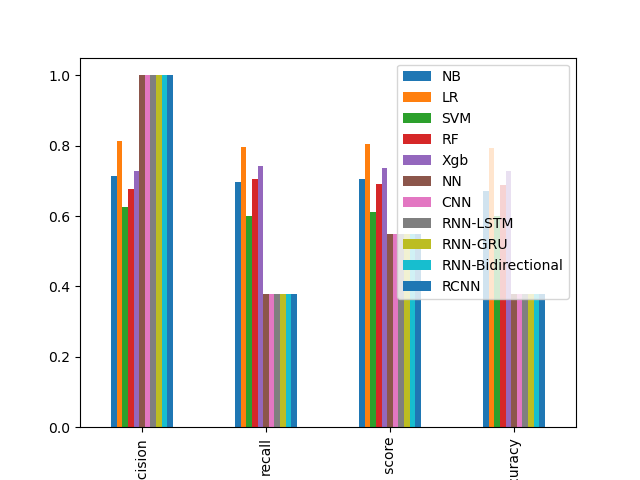

In [191]:
df_compare = pd.DataFrame(accuracy_compareTab, index = ['precision', 'recall', 'f1 score', 'accuracy'])
df_compare.plot(kind='bar')

## Dane bez normalizacji tekstu

In [192]:
#podział zbioru na dane testowe i treningowe
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDFRaw['OriginalTweet'], trainDFRaw['Sentiment'])

#zmiana etykiet na numeryczne
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(trainDFRaw['OriginalTweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(trainDFRaw['OriginalTweet'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(trainDFRaw['OriginalTweet'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x) 

D:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


## Klasyfikatory

In [193]:
#NB
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab2 = {'NBRaw':accuracy}

In [194]:
#LR
accuracy = train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab2['LRRaw'] =  accuracy

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [195]:
#SVM
accuracy = train_model(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
accuracy_compareTab2['SVMRaw'] =  accuracy

In [196]:
#RF
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
accuracy_compareTab2['RFRaw'] =  accuracy

In [197]:
#Xgb
accuracy = train_model(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
accuracy_compareTab2['XgbRaw'] =  accuracy

D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:09:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<IPython.core.display.Javascript object>


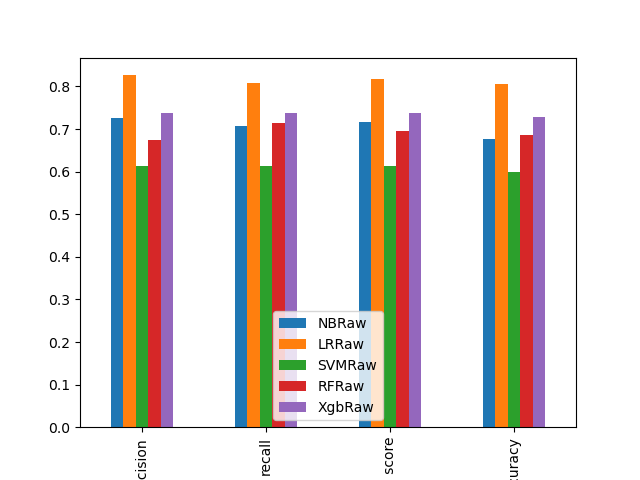

In [198]:
df_compare2 = pd.DataFrame(accuracy_compareTab2, index = ['precision', 'recall', 'f1 score', 'accuracy'])
df_compare2.plot(kind='bar')